In [37]:
import pandas as pd
import numpy as np
from metalib import metaga_for_test
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
from metalib.utils import split_dataframe, load_hist_data

## MetaGA Update
Let's try different symbols and assess how is the XGBClassifier + Calibrated CV using isotonic regression.
But first, what is isotonic regression ? How is it used here ?

## What the analysis should yield ?

- Is it better to fine-tune the length of the long/medium/short factors for each symbols or is it ok to use the same ?
- Should you subsample returns to predict/focus on tails ?
- Should you make one model for long predictions ? and one for short ?

If we can answer those, think we can get to a predict good level on this strategy.

In [3]:
price_df = load_hist_data("EURUSD", 2023)

C:\Users\Trismegist\anaconda3\envs\adonys\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [4]:
ins_list, ous_list = split_dataframe(price_df, insample_days=66, outsample_days=10)
ins, ous = ins_list[0], ous_list[0]

In [5]:
strategy = metaga_for_test.MetaGA(   high_length= 1440,
                            low_length= 60,
                            mid_length= 480,
                            prob_bound= 0.075,
                            size_position= 0.08,
                            symbols=["EURUSD"],
                            tag="metaga_test",
                            timeframe="mt5.TIMEFRAME_M1",
                            active_hours=None
                            )

In [6]:
strategy.data = {"EURUSD": ins}

In [7]:
strategy.fit()

metaga_test::: Computed rolling volatilies
metaga_test::: Computed rolling skewness
metaga_test::: Computed rolling kurtosis
metaga_test::: Computed rolling mean crossings
metaga_test::: Computed rolling OLS t-values
metaga_test::: Computed technical indicators
metaga_test::: Merged indicators
metaga_test::: Target filter ratio: 0.2
metaga_test::: Actual filter ratio: 0.2006
metaga_test::: Solved extrema bound: 0.7929
metaga_test::: Number of rows after filter: 8163
metaga_test::: XGBoost Model trained from 2023-02-09 11:03:00 to 2023-04-03 23:50:00 pelo.
metaga_test::: XGBoost Model and first/second moments saved.


In [9]:
model = strategy.model

In [27]:
predictions = []
quorums = []
votes = []

indicators = strategy.retrieve_indicators(ous)
indicators = (indicators - strategy.indicators_mean) / strategy.indicators_std

for idx in tqdm(range(1441, indicators.shape[0])):
    indicators_sub = indicators.iloc[idx - 1440:idx]
    indicators_sub = indicators_sub.tail(3)

    dummy_extremes_indicators = abs(indicators_sub) > strategy.indicator_extrema_bound
    vote = np.sum(dummy_extremes_indicators.iloc[-1])
    quorum = int(dummy_extremes_indicators.shape[1] / 2)

    y_hat = model.predict_proba(indicators_sub)[:, 1]
    predictions.append(y_hat)
    votes.append(vote)
    quorums.append(quorum)

metaga_test::: Computed rolling volatilies
metaga_test::: Computed rolling skewness
metaga_test::: Computed rolling kurtosis
metaga_test::: Computed rolling mean crossings
metaga_test::: Computed rolling OLS t-values
metaga_test::: Computed technical indicators
metaga_test::: Merged indicators


  0%|          | 0/9283 [00:00<?, ?it/s]

In [32]:
model_estimates = pd.concat([pd.DataFrame(predictions, columns=["pred_a", "pred_b", "pred_c"]),
                             pd.DataFrame(votes, columns=["vote"]),
                             pd.DataFrame(quorums, columns=["quorum"])],
                            axis=1)

In [74]:
ret_cc = np.log(ous["close"]).diff()
vol_sess = np.sqrt(
    ret_cc.rolling(strategy.mid_length).apply(lambda x: (x**2).sum(), raw=True)
)
y_raw = ret_cc.rolling(strategy.mid_length).sum().shift(-strategy.mid_length) / vol_sess
next_five_returns = (y_raw < 0).astype(int).dropna()

In [62]:
model_estimates["is_quorum"] = model_estimates.apply(lambda x: x["vote"] >= x["quorum"], axis=1)

<Axes: >

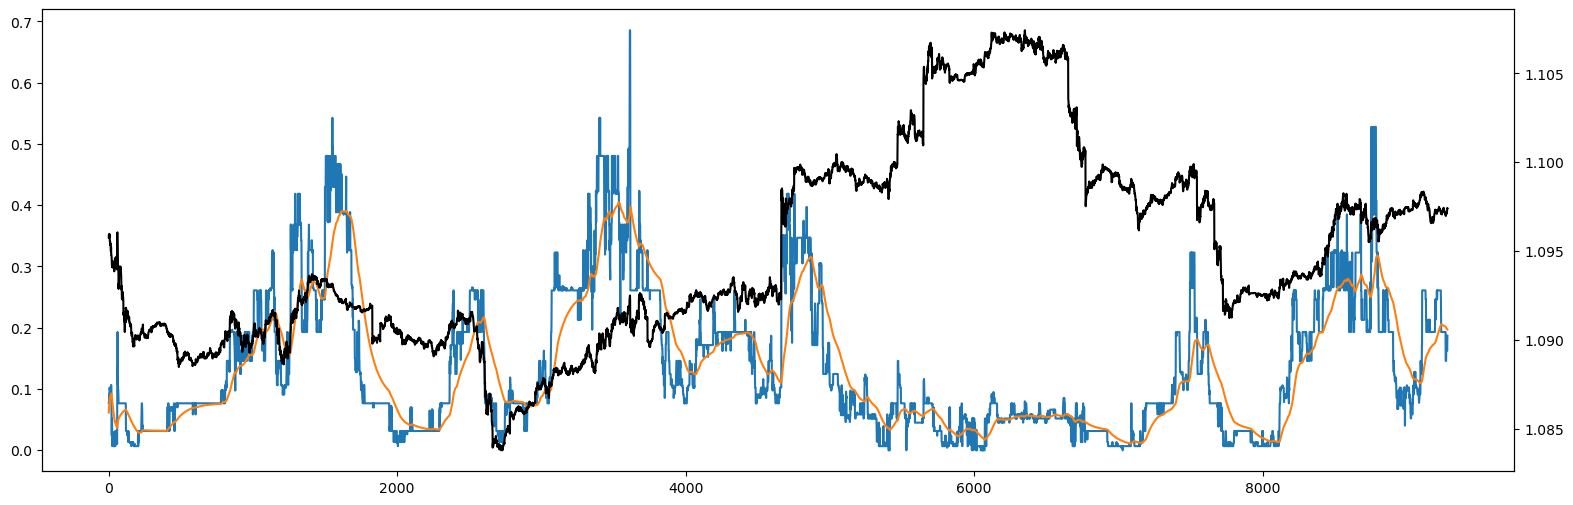

In [78]:
fig, ax = plt.subplots(figsize=(19, 6))
ax1 = ax.twinx()

model_estimates["pred_c"].plot(ax=ax)
model_estimates[["pred_a", "pred_b", "pred_c"]].mean(axis=1).ewm(halflife=60).mean().plot(ax=ax)

ous["close"].tail(model_estimates.shape[0]).reset_index(drop=True).plot(ax=ax1, color="black", label="Actual")

In [79]:
model_estimates["is_long"] = model_estimates["is_quorum"] & (model_estimates["pred_c"] > 1 - strategy.prob_bound)
model_estimates["is_short"] = model_estimates["is_quorum"] & (model_estimates["pred_c"] < strategy.prob_bound)

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [82]:
(model_estimates["is_short"] & next_five_returns.tail(model_estimates.shape[0]).reset_index(drop=True))

0       False
1       False
2       False
3       False
4       False
        ...  
9278    False
9279    False
9280    False
9281    False
9282    False
Length: 9283, dtype: bool

In [88]:
confusion_matrix(next_five_returns.tail(model_estimates.shape[0]).reset_index(drop=True),
                 model_estimates["is_short"])
print(accuracy_score(next_five_returns.tail(model_estimates.shape[0]).reset_index(drop=True),
                     model_estimates["is_short"]))

0.6188732090918884


In [56]:
(next_five_returns.tail(model_estimates.shape[0]).reset_index(drop=True) < 0).value_counts()

close
False    9283
Name: count, dtype: int64

time
2023-04-04 00:00:00         NaN
2023-04-04 00:01:00         NaN
2023-04-04 00:02:00         NaN
2023-04-04 00:03:00         NaN
2023-04-04 00:04:00         NaN
                         ...   
2023-04-18 23:55:00    0.001615
2023-04-18 23:56:00    0.001608
2023-04-18 23:57:00    0.001550
2023-04-18 23:58:00    0.001548
2023-04-18 23:59:00    0.001548
Name: close, Length: 10725, dtype: float64